In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import copy

In [2]:
# 훈련(train)과 테스트(val)를 위한 데이터 변형
data_transforms = {
    'train': transforms.Compose([
        # 먼저 이미지에 랜덤한 네모 부분을 선정후 지정 크기만큼 크롭
        transforms.RandomResizedCrop(224), 
        # 0.5의 확률로 수평방향으로의 대칭 이동
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        # 이미지 크기 조정
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## 디렉토리구조
# 데이터가 위치한 디렉토리: data_dir
# data_dir
# > train
#   > dog
#   > goat
#   > lamb
# > val
#   > dog
#   > goat
#   > lamb
data_dir = 'data/transferlearning/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=4,
                                              shuffle=True)
              for x in ['train', 'val']}
# 데이터 크기 확인
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# 카테고리 이름 확인 
class_names = image_datasets['train'].classes
# 디바이저 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

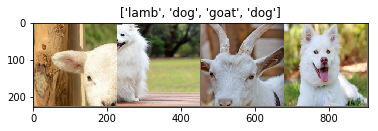

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [5]:
def get_model(num_classes, freeze_conv=False):
    """
    num_classes: 
        새로운 분류기를 만들기 위한 카테고리의 개수
    freeze_conv: 
        합성곱 신경망 층은 미리 훈련된 파라미터로 두고, 
        완전 연결층만 바꾼다.
    """
    model = models.resnet18(pretrained=True)
    if freeze_conv:
        for param in model.parameters():
            param.requires_grad = False
    # 최종 fc 층의 입력 크기
    in_feature = model.fc.in_features
    # 새로 정의한 nn.Linear로 바꿔준다.
    model.fc = nn.Linear(in_feature, num_classes)
    return model

# 모델 정의 
model = get_model(len(class_names), freeze_conv=False).to(device)
# 손실함수 정의
loss_function = nn.CrossEntropyLoss()
# 옵티마이저 정의
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Observe that all parameters are being optimized

In [6]:
def train_model(model, criterion, optimizer, device, n_step=25):
    """
    훈련함수:
    https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
    에서 약간 변형
    """
    # 제일 성능이 좋았던 모델의 상태를 저장하기 위한 변수 정의
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for step in range(n_step):
        print('Step {}/{}'.format(step+1, n_step))
        print('-' * 10)

        # 매 스텝마다 훈련과 평가를 반복한다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 훈련 모드로 전환
            else:
                model.eval()   # 모델을 평가 모드로 전환
            
            running_loss = 0.0
            running_corrects = 0

            # 훈련 시작
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 경사 초기화
                optimizer.zero_grad()

                # 순방향 전파
                # 빠른 계산을 위해서 훈련 모드에만 경사를 추적하게 한다
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # 손실값 계산
                    loss = criterion(outputs, labels)

                    # 훈련 단계에서만 역전파 + 매개변수 업데이트를 진행
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 한 번의 미니배치의 손실값 및 정확도 계산
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            # 한 스텝의 손실값 및 정확도 계산
            step_loss = running_loss / dataset_sizes[phase]
            step_acc = running_corrects.double() / dataset_sizes[phase]

            print('{}\t Loss: {:.4f}\t Acc: {:.4f}'.format(
                phase, step_loss, step_acc))

            # 평가 단계에서만 정확도를 기준으로 모델 상태 저장
            if phase == 'val' and step_acc > best_acc:
                best_acc = step_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    
    print('Best val Acc: {:4f}'.format(best_acc))

    # 제일 학습이 좋았던 상태를 불러온다.
    model.load_state_dict(best_model_wts)
    return model

In [7]:
model = train_model(model, loss_function, optimizer, device, n_step=15)

Step 1/15
----------
train	 Loss: 1.1187	 Acc: 0.3818
val	 Loss: 0.7176	 Acc: 0.6667

Step 2/15
----------
train	 Loss: 0.6010	 Acc: 0.7455
val	 Loss: 0.6519	 Acc: 0.5000

Step 3/15
----------
train	 Loss: 0.3659	 Acc: 0.8727
val	 Loss: 0.1386	 Acc: 1.0000

Step 4/15
----------
train	 Loss: 0.7758	 Acc: 0.7091
val	 Loss: 0.3028	 Acc: 0.8333

Step 5/15
----------
train	 Loss: 0.4651	 Acc: 0.8000
val	 Loss: 0.1375	 Acc: 1.0000

Step 6/15
----------
train	 Loss: 0.2987	 Acc: 0.8364
val	 Loss: 0.1619	 Acc: 1.0000

Step 7/15
----------
train	 Loss: 0.6454	 Acc: 0.7818
val	 Loss: 0.2371	 Acc: 1.0000

Step 8/15
----------
train	 Loss: 0.2087	 Acc: 0.9091
val	 Loss: 0.4573	 Acc: 0.6667

Step 9/15
----------
train	 Loss: 0.3458	 Acc: 0.8909
val	 Loss: 0.1040	 Acc: 1.0000

Step 10/15
----------
train	 Loss: 0.3820	 Acc: 0.8364
val	 Loss: 0.1160	 Acc: 1.0000

Step 11/15
----------
train	 Loss: 0.1038	 Acc: 0.9636
val	 Loss: 0.1584	 Acc: 1.0000

Step 12/15
----------
train	 Loss: 0.2777	 Acc: 0.87

# Validation

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        plt.tight_layout()
        model.train(mode=was_training)

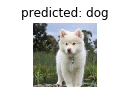

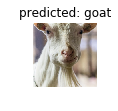

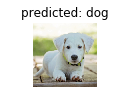

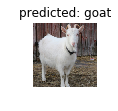

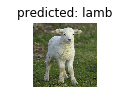

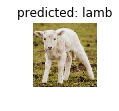

In [9]:
visualize_model(model)

# Test

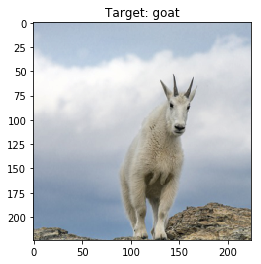

In [22]:
# 테스트 데이터 전처리 및 확인
test_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), test_tf)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)
inputs, label = next(iter(test_loader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title="Target: "+class_names[label])

In [23]:
# 테스트 이미지 예측
pred = model(inputs.to(device)).argmax(1)
print(class_names[pred])

goat
